In [1]:
# mount Google Drive root
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [0]:
# reset computational graphs
def reset():
  
  tf.reset_default_graph()

In [0]:
# load data and permute
data1 = np.load("gdrive/My Drive/data/data1.npy")

data2 = np.load("gdrive/My Drive/data/data2.npy")

data3 = np.load("gdrive/My Drive/data/data3.npy")

data4 = np.load("gdrive/My Drive/data/data4.npy")

data5 = np.load("gdrive/My Drive/data/data5.npy")

data6 = np.load("gdrive/My Drive/data/data6.npy")

data7 = np.load("gdrive/My Drive/data/data7.npy")

data8 = np.load("gdrive/My Drive/data/data8.npy")

data9 = np.load("gdrive/My Drive/data/data9.npy")

data10 = np.load("gdrive/My Drive/data/data10.npy")

data = np.vstack((data1, data2, data3, data4, data5, data6, data7, data8, data9, data10))

data_height, data_width, data_channels = data[0].shape[0], data[0].shape[1], data[0].shape[2]

labels = np.load("gdrive/My Drive/data/labels.npy")

masks = np.load("gdrive/My Drive/data/masks.npy")

stars = np.load("gdrive/My Drive/data/stars.npy")

iou_ids = np.load("gdrive/My Drive/data/iou_ids.npy")

car_masks = np.load("gdrive/My Drive/data/car_masks.npy")

ppl_masks = np.load("gdrive/My Drive/data/ppl_masks.npy")

permutation = np.random.permutation(data.shape[0])

data_s = data[permutation]

labels_s = labels[permutation]

masks_s = masks[permutation]

stars_s = stars[permutation]

iou_ids_s = iou_ids[permutation]

car_masks_s = car_masks[permutation]

ppl_masks_s =  ppl_masks[permutation]

training_data = data_s[:1600]
testing_data = data_s[1600:]

num_training_examples = 1600
num_testing_examples = 400

training_labels = labels_s[:1600]
testing_labels = labels_s[1600:]

training_masks = masks_s[:1600]
testing_masks = masks_s[1600:]

training_stars = stars_s[:1600]
testing_stars = stars_s[1600:]

training_iou_ids = iou_ids_s[:1600]
testing_iou_ids = iou_ids_s[1600:]

training_car_masks = car_masks_s[:1600]
testing_car_masks = car_masks_s[1600:]

training_ppl_masks = ppl_masks_s[:1600]
testing_ppl_masks = ppl_masks_s[1600:]

training_epochs = 20

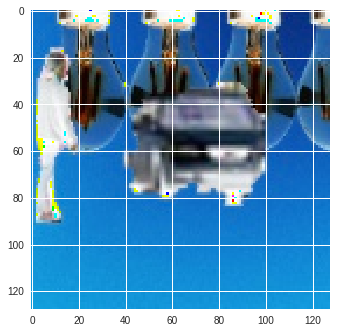

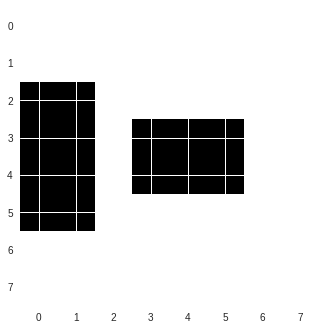

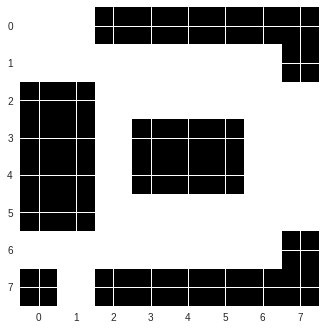

In [18]:
# visualize a data point, its label and mask (containing only the regions we are interested)
plt.imshow(data_s[160])
plt.show()

plt.imshow(labels_s[160])
plt.show()

plt.imshow(masks_s[160])
plt.show()

In [0]:
reset()

# base CNN architecture for RPN
def cnn(x):

    conv1 = tf.nn.relu(tf.layers.batch_normalization(tf.layers.conv2d(x, filters=8, kernel_size=[3,3], padding="SAME", kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1), name="conv1"), name="bn1"), name="relu1")
    
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=2, strides=2, name="p1")
    
    conv2 = tf.nn.relu(tf.layers.batch_normalization(tf.layers.conv2d(pool1, filters=16, kernel_size=[3,3], padding="SAME", kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1), name="conv2"), name="bn2"), name="relu2")
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=2, strides=2, name="p2")
    
    conv3 = tf.nn.relu(tf.layers.batch_normalization(tf.layers.conv2d(pool2, filters=32, kernel_size=[3,3], padding="SAME", kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1), name="conv3"), name="bn3"), name="relu3")
    
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=2, strides=2, name="p3")
    
    conv4 = tf.nn.relu(tf.layers.batch_normalization(tf.layers.conv2d(pool3, filters=64, kernel_size=[3,3], padding="SAME", kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1), name="conv4"), name="bn4"), name="relu4")
    
    pool4 = tf.layers.max_pooling2d(inputs=conv4, pool_size=2, strides=2, name="p4")
    
    conv5 = tf.nn.relu(tf.layers.batch_normalization(tf.layers.conv2d(pool4, filters=128, kernel_size=[3,3], padding="SAME", kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1), name="conv5"), name="bn5"), name="relu5")
  
    intermediate_features_1 = tf.nn.relu(tf.layers.batch_normalization(tf.layers.conv2d(conv5, filters=128, kernel_size=[3,3], padding="SAME", kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1), name="int6"), name="bn6"), name="relu6")
    
    intermediate_features_2a = tf.layers.conv2d(intermediate_features_1, filters=1, kernel_size=[1,1], padding="SAME", kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1), name="int7")
    
    intermediate_features_2b = tf.layers.conv2d(intermediate_features_1, filters=4, kernel_size=[1,1], padding="SAME", kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1), bias_initializer=tf.constant_initializer([4,4,8,8]), name="int8")
    
    return conv5, intermediate_features_2a, intermediate_features_2b

In [0]:
# CLS layer of RPN
def rpn_classification(training_data, testing_data, training_labels, testing_labels, training_masks, testing_masks):
  
  # tf graph inputs
  x1 = tf.placeholder("float", [None, data_height, data_width, data_channels])
  y1 = tf.placeholder("float", [None, 8, 8, 1])
  y2 = tf.placeholder("float", [None, 8, 8, 1])

  # model feature predictions
  _, features, _ = cnn(x1)

  # define loss and optimizer
  entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = y1, logits = features)
  loss_op = tf.reduce_mean(tf.boolean_mask(entropy, y2))
  optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
  train_op = optimizer.minimize(loss_op)

  # metrics and functions for model evaluation
  y_hat = tf.cast(tf.round(tf.nn.sigmoid(features)), tf.float32)

  correct_prediction = tf.cast(tf.equal(y_hat, y1), tf.float32)
  
  accuracy_operation = tf.reduce_mean(tf.boolean_mask(correct_prediction, y2))
  
  # initializing the variables
  init = tf.global_variables_initializer()

  with tf.Session() as sess:

      sess.run(init)

      training_loss_list = []
      testing_accuracy_list = []
      
      # training cycle
      for epoch in range(training_epochs):

          total_loss = 0.
          total_accuracy = 0.
          
          batch_size = 1
          
          # loop over all batches
          for i in range(0, num_training_examples, batch_size):

              train_x, train_label, train_mask = training_data[i:i+batch_size], training_labels[i:i+batch_size], training_masks[i:i+batch_size]
              
              train_label = train_label[:, :, :, np.newaxis]
              train_mask = train_mask[:, :, :, np.newaxis]
              
              _, loss = sess.run([train_op, loss_op], feed_dict={x1: train_x, y1: train_label, y2: train_mask})
              
              total_loss += loss 

          total_loss = total_loss/num_training_examples    
          
          if(epoch%2 == 0):
            print("\nEpoch: ", epoch+1, ", Training Loss: ", total_loss, "\n")

          training_loss_list.append(total_loss)
          
          for j in range(0, num_testing_examples):
            
              test_x, test_label, test_mask = testing_data[j], testing_labels[j], testing_masks[j]
              
              test_x = test_x[np.newaxis, :, :, :]
              test_label = test_label[np.newaxis, :, :, np.newaxis]
              test_mask = test_mask[np.newaxis, :, :, np.newaxis]
              
              accuracy = sess.run([accuracy_operation], feed_dict={x1: test_x, y1: test_label, y2: test_mask})

              total_accuracy += accuracy[0]
              
          total_accuracy = total_accuracy/num_testing_examples 
          
          testing_accuracy_list.append(total_accuracy)
              
      plt.plot(np.arange(len(training_loss_list))+1, training_loss_list)
      plt.xlabel("Number of epochs")
      plt.ylabel("Training loss")
      plt.show()
      
      plt.plot(np.arange(len(testing_accuracy_list))+1, testing_accuracy_list)
      plt.xlabel("Number of epochs")
      plt.ylabel("Testing accuracy")
      plt.show()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Epoch:  1 , Training Loss:  0.3607358522774302 


Epoch:  3 , Training Loss:  0.16543865686812978 


Epoch:  5 , Training Loss:  0.12727597661195206 


Epoch:  7 , Training Loss:  0.09676358391379063 


Epoch:  9 , Training Loss:  0.06985725493038224 


Epoch:  11 , Training Loss:  0.05714671474494765 


Epoch:  13 , Training Loss:  0.0438823086993059 


Epoch:  15 , Training Loss:  0.04063062911539205 


Epoch:  17 , Training Loss:  0.030787952115046372 


Epoch:  19 , Training Loss:  0.03054628465898828 



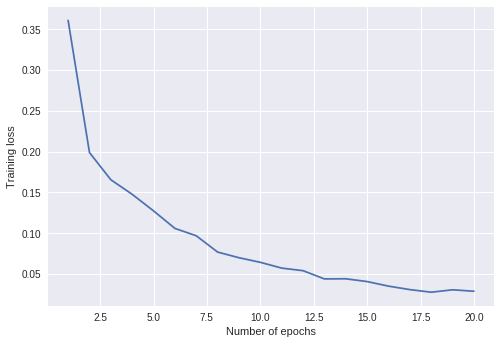

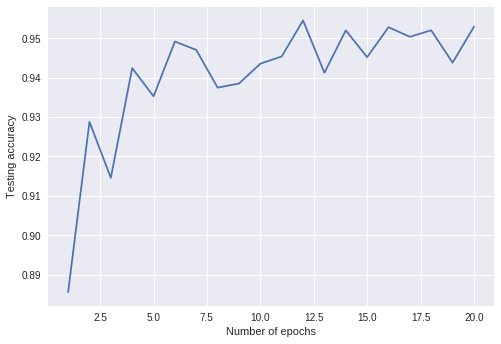

In [8]:
rpn_classification(training_data, testing_data, training_labels, testing_labels, training_masks, testing_masks)

In [0]:
# L1 loss for REG of RPN
def l1_loss(t_star):
  
  diff = tf.identity(t_star)
  
  abs_diff = tf.abs(diff)
  
  l1_loss = tf.where(abs_diff < 1, 0.5 * tf.square(diff), abs_diff - 0.5)
  
  return l1_loss

In [0]:
reset()

# CLS + REG layers of RPN
def rpn_classification_and_regression(training_data, testing_data, training_labels, testing_labels, training_masks, testing_masks, training_stars, testing_stars, w_a):
  
  # tf graph inputs
  x1 = tf.placeholder("float", [None, data_height, data_width, data_channels])
  y1 = tf.abs(tf.placeholder("float", [None, 8, 8, 1]))
  y2 = tf.abs(tf.placeholder("float", [None, 8, 8, 1]))
  stars = tf.placeholder("float", [None, 8, 8, 4])

  # model feature predictions
  _, cls_features, reg_features = cnn(x1)
  
  # objectness predictions
  cls_features_activations = tf.nn.sigmoid(cls_features)
  
  # CLS loss
  entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = y1, logits = cls_features)
  loss_op_1 = tf.reduce_mean(tf.boolean_mask(entropy, y2))
  
  # regression predictions
  x = reg_features[:, :, :, 0]
  y = reg_features[:, :, :, 1]
  w = reg_features[:, :, :, 2]
  h = reg_features[:, :, :, 3]
  
  epsilon = 1e-05
  
  x_star = stars[:, :, :, 0]
  
  t_x_star = (x - x_star)/float(w_a)
  
  t_x = tf.boolean_mask(t_x_star, y2[:,:,:,0])
  
  y_star = stars[:, :, :, 1]
  
  t_y_star = (y - y_star)/float(w_a)
  
  t_y = tf.boolean_mask(t_y_star, y2[:,:,:,0])
 
  w_star = stars[:, :, :, 2]
  
  t_w_star = tf.log((w/(w_star + epsilon) + epsilon))
  
  t_w = tf.boolean_mask(t_w_star, y2[:,:,:,0])
  
  t_w_new = tf.where(tf.is_nan(t_w), tf.zeros_like(t_w), t_w)
  
  h_star = stars[:, :, :, 3]
  
  t_h_star = tf.log((h/(h_star + epsilon) + epsilon))
  
  t_h = tf.boolean_mask(t_h_star, y2[:,:,:,0])
  
  t_h_new = tf.where(tf.is_nan(t_h), tf.zeros_like(t_h), t_h)
  
  # REG loss
  loss_op_2 = tf.reduce_mean(l1_loss(t_x) + l1_loss(t_y) + l1_loss(t_w_new) + l1_loss(t_h_new))/4.0
  
  # total loss
  loss_op = loss_op_1 + loss_op_2
  
  # optimzer
  optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
  train_op = optimizer.minimize(loss_op)
  
  # initializing the variables
  init = tf.global_variables_initializer()
  
  with tf.Session() as sess:

      sess.run(init)

      training_reg_loss_list = []
      testing_reg_loss_list = []
      
      # training cycle
      for epoch in range(training_epochs):

          total_loss_tr = 0.
          total_loss_ts = 0.
          
          training_cls_features = []
          training_reg_features = []
          
          testing_cls_features = []
          testing_reg_features = []
          
          batch_size = 1
          
          # loop over all batches
          for i in range(0, num_training_examples, batch_size):

              train_x, train_label, train_mask, training_star_all = training_data[i:i+batch_size], training_labels[i:i+batch_size], training_masks[i:i+batch_size], training_stars[i:i+batch_size]
              
              train_label = train_label[:, :, :, np.newaxis]
              train_mask = train_mask[:, :, :, np.newaxis]
              
              _, _, reg_loss, cls_f, reg_f = sess.run([train_op, loss_op, loss_op_2, cls_features_activations, reg_features], feed_dict={x1: train_x, y1: train_label, y2: train_mask, stars: training_star_all})
              
              total_loss_tr += reg_loss 
              
              if(epoch%19 == 0):
                training_cls_features.append(cls_f[0])
                training_reg_features.append(reg_f[0])
              
          total_loss_tr = total_loss_tr/num_training_examples    
          
          training_reg_loss_list.append(total_loss_tr)
          
          if(epoch%2 == 0):
            print("\nEpoch: ", epoch+1, ", Training Loss: ", total_loss_tr, "\n")
          
          for j in range(0, num_testing_examples):
            
              test_x, test_label, test_mask, test_star_all = testing_data[j], testing_labels[j], testing_masks[j], testing_stars[j]
              
              test_x = test_x[np.newaxis, :, :, :]
              test_label = test_label[np.newaxis, :, :, np.newaxis]
              test_mask = test_mask[np.newaxis, :, :, np.newaxis]
              test_star_all = test_star_all[np.newaxis, :, :, :]
              
              loss, reg_loss, cls_f, reg_f = sess.run([loss_op, loss_op_2, cls_features_activations, reg_features], feed_dict={x1: test_x, y1: test_label, y2: test_mask, stars: test_star_all})

              total_loss_ts += reg_loss
              
              if(epoch%19 == 0):
                testing_cls_features.append(cls_f[0])
                testing_reg_features.append(reg_f[0])
          
          total_loss_ts = total_loss_ts/num_testing_examples
          
          testing_reg_loss_list.append(total_loss_ts)
          
          if(epoch == 19):
            print("\nFinal Testing Loss: ", total_loss_ts, "\n")
      
      # final CLS and REG predictions
      cls_features = np.vstack((np.array(training_cls_features), np.array(testing_cls_features)))
      reg_features = np.vstack((np.array(training_reg_features), np.array(testing_reg_features)))
      
      plt.plot(np.arange(len(training_reg_loss_list))+1, training_reg_loss_list)
      plt.xlabel("Number of epochs")
      plt.ylabel("Training regression loss")
      plt.show()
      
      return cls_features, reg_features

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Epoch:  1 , Training Loss:  0.23342325869947672 


Epoch:  3 , Training Loss:  0.10832447317312471 


Epoch:  5 , Training Loss:  0.09772807464469224 


Epoch:  7 , Training Loss:  0.09634695257002023 


Epoch:  9 , Training Loss:  0.09317156234930735 


Epoch:  11 , Training Loss:  0.08734657027816865 


Epoch:  13 , Training Loss:  0.0857189691986423 


Epoch:  15 , Training Loss:  0.08299573291209526 


Epoch:  17 , Training Loss:  0.0802614178112708 


Epoch:  19 , Training Loss:  0.07855959452572278 


Final Testing Loss:  0.10306566316634416 



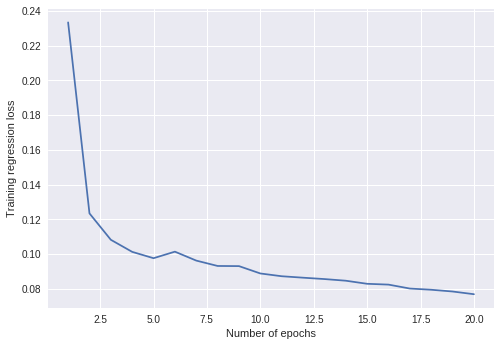

In [11]:
cls_features, reg_features = rpn_classification_and_regression(training_data, testing_data, training_labels, testing_labels, training_masks, testing_masks, training_stars, testing_stars, w_a=3)

In [0]:
# spatial transformer code provided

def transformer(U, theta, out_size, name='SpatialTransformer', **kwargs):
    """Spatial Transformer Layer

    Implements a spatial transformer layer as described in [1]_.
    Based on [2]_ and edited by David Dao for Tensorflow.

    Parameters
    ----------
    U : float
        The output of a convolutional net should have the
        shape [num_batch, height, width, num_channels].
    theta: float
        The output of the
        localisation network should be [num_batch, 6].
    out_size: tuple of two ints
        The size of the output of the network (height, width)

    References
    ----------
    .. [1]  Spatial Transformer Networks
            Max Jaderberg, Karen Simonyan, Andrew Zisserman, Koray Kavukcuoglu
            Submitted on 5 Jun 2015
    .. [2]  https://github.com/skaae/transformer_network/blob/master/transformerlayer.py

    Notes
    -----
    To initialize the network to the identity transform init
    ``theta`` to :
        identity = np.array([[1., 0., 0.],
                             [0., 1., 0.]])
        identity = identity.flatten()
        theta = tf.Variable(initial_value=identity)

    """

    def _repeat(x, n_repeats):
        with tf.variable_scope('_repeat'):
            rep = tf.transpose(
                tf.expand_dims(tf.ones(shape=tf.stack([n_repeats, ])), 1), [1, 0])
            rep = tf.cast(rep, 'int32')
            x = tf.matmul(tf.reshape(x, (-1, 1)), rep)
            return tf.reshape(x, [-1])

    def _interpolate(im, x, y, out_size):
        with tf.variable_scope('_interpolate'):
            # constants
            num_batch = tf.shape(im)[0]
            height = tf.shape(im)[1]
            width = tf.shape(im)[2]
            channels = tf.shape(im)[3]

            x = tf.cast(x, 'float32')
            y = tf.cast(y, 'float32')
            height_f = tf.cast(height, 'float32')
            width_f = tf.cast(width, 'float32')
            out_height = out_size[0]
            out_width = out_size[1]
            zero = tf.zeros([], dtype='int32')
            max_y = tf.cast(tf.shape(im)[1] - 1, 'int32')
            max_x = tf.cast(tf.shape(im)[2] - 1, 'int32')

            # scale indices from [-1, 1] to [0, width/height]
            x = (x + 1.0)*(width_f-1-1e-6) / 2.0
            y = (y + 1.0)*(height_f-1-1e-6) / 2.0

            # do sampling
            x0 = tf.cast(tf.floor(x), 'int32')
            x1 = x0 + 1
            y0 = tf.cast(tf.floor(y), 'int32')
            y1 = y0 + 1

            x0 = tf.clip_by_value(x0, zero, max_x)
            x1 = tf.clip_by_value(x1, zero, max_x)
            y0 = tf.clip_by_value(y0, zero, max_y)
            y1 = tf.clip_by_value(y1, zero, max_y)
            dim2 = width
            dim1 = width*height
            base = _repeat(tf.range(num_batch)*dim1, out_height*out_width)
            base_y0 = base + y0*dim2
            base_y1 = base + y1*dim2
            idx_a = base_y0 + x0
            idx_b = base_y1 + x0
            idx_c = base_y0 + x1
            idx_d = base_y1 + x1

            # use indices to lookup pixels in the flat image and restore
            # channels dim
            im_flat = tf.reshape(im, tf.stack([-1, channels]))
            im_flat = tf.cast(im_flat, 'float32')
            Ia = tf.gather(im_flat, idx_a)
            Ib = tf.gather(im_flat, idx_b)
            Ic = tf.gather(im_flat, idx_c)
            Id = tf.gather(im_flat, idx_d)

            # and finally calculate interpolated values
            x0_f = tf.cast(x0, 'float32')
            x1_f = tf.cast(x1, 'float32')
            y0_f = tf.cast(y0, 'float32')
            y1_f = tf.cast(y1, 'float32')
            wa = tf.expand_dims(((x1_f-x) * (y1_f-y)), 1)
            wb = tf.expand_dims(((x1_f-x) * (y-y0_f)), 1)
            wc = tf.expand_dims(((x-x0_f) * (y1_f-y)), 1)
            wd = tf.expand_dims(((x-x0_f) * (y-y0_f)), 1)
            output = tf.add_n([wa*Ia, wb*Ib, wc*Ic, wd*Id])
            return output

    def _meshgrid(height, width):
        with tf.variable_scope('_meshgrid'):
            # This should be equivalent to:
            #  x_t, y_t = np.meshgrid(np.linspace(-1, 1, width),
            #                         np.linspace(-1, 1, height))
            #  ones = np.ones(np.prod(x_t.shape))
            #  grid = np.vstack([x_t.flatten(), y_t.flatten(), ones])
            x_t = tf.matmul(tf.ones(shape=tf.stack([height, 1])),
                            tf.transpose(tf.expand_dims(tf.linspace(-1.0, 1.0, width), 1), [1, 0]))
            y_t = tf.matmul(tf.expand_dims(tf.linspace(-1.0, 1.0, height), 1),
                            tf.ones(shape=tf.stack([1, width])))

            x_t_flat = tf.reshape(x_t, (1, -1))
            y_t_flat = tf.reshape(y_t, (1, -1))

            ones = tf.ones_like(x_t_flat)
            grid = tf.concat(axis=0, values=[x_t_flat, y_t_flat, ones])
            return grid

    def _transform(theta, input_dim, out_size):
        with tf.variable_scope('_transform'):
            num_batch = tf.shape(input_dim)[0]
            height = tf.shape(input_dim)[1]
            width = tf.shape(input_dim)[2]
            num_channels = tf.shape(input_dim)[3]
            theta = tf.reshape(theta, (-1, 2, 3))
            theta = tf.cast(theta, 'float32')

            # grid of (x_t, y_t, 1), eq (1) in ref [1]
            height_f = tf.cast(height, 'float32')
            width_f = tf.cast(width, 'float32')
            out_height = out_size[0]
            out_width = out_size[1]
            grid = _meshgrid(out_height, out_width)
            grid = tf.expand_dims(grid, 0)
            grid = tf.reshape(grid, [-1])
            grid = tf.tile(grid, tf.stack([num_batch]))
            grid = tf.reshape(grid, tf.stack([num_batch, 3, -1]))

            # Transform A x (x_t, y_t, 1)^T -> (x_s, y_s)
            T_g = tf.matmul(theta, grid)
            x_s = tf.slice(T_g, [0, 0, 0], [-1, 1, -1])
            y_s = tf.slice(T_g, [0, 1, 0], [-1, 1, -1])
            x_s_flat = tf.reshape(x_s, [-1])
            y_s_flat = tf.reshape(y_s, [-1])

            input_transformed = _interpolate(
                input_dim, x_s_flat, y_s_flat,
                out_size)

            output = tf.reshape(
                input_transformed, tf.stack([num_batch, out_height, out_width, num_channels]))
            return output

    with tf.variable_scope(name):
        output = _transform(theta, U, out_size)
        return output

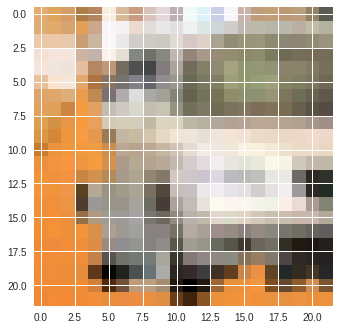

In [19]:
# visualize for the image shown above

U = data_s[160]
U = U[np.newaxis, :, :, :]

cls_f = cls_features[160]

# get the maximally activated proposal (top-1)
idx = np.argmax(cls_f.flatten())

x = reg_features[160][:,:,0].flatten()
x_req = x[idx]

y = reg_features[160][:,:,1].flatten()
y_req = y[idx]

w = reg_features[160][:,:,2].flatten()
w_req = w[idx]

h = reg_features[160][:,:,3].flatten()
h_req = h[idx]

theta = np.zeros((1,6))

theta[:,0] = w_req*16/128.0

theta[:,2] = (x_req*16 - 64)/64.0

theta[:,4] = w_req*16/128.0

theta[:,5] = (y_req*16 - 64)/64.0

# 22x22 warped roi
output = transformer(U=U, theta=theta, out_size=(22,22), name='SpatialTransformer_1')

with tf.Session() as s1:
  o = s1.run([output])
  o_ = o[0][0].astype(np.uint8)
  plt.imshow(o_)
  plt.show()

In [0]:
reset()

# Faster R-CNN
def faster_rcnn(permutation, training_data, testing_data, training_labels, testing_labels, training_masks, testing_masks, training_stars, testing_stars, training_iou_ids, testing_iou_ids, w_a):
  
  batch_size = 1
  
  # tf graph inputs
  x1 = tf.placeholder("float", [batch_size, data_height, data_width, data_channels])
  y1 = tf.abs(tf.placeholder("float", [batch_size, 8, 8, 1]))
  y2 = tf.abs(tf.placeholder("float", [batch_size, 8, 8, 1]))
  stars = tf.placeholder("float", [batch_size, 8, 8, 4])
  y3 = tf.placeholder("float", [batch_size, 8, 8, 1])

  # feature predictions
  conv5, cls_features, reg_features = cnn(x1)
  
  """
  
  RPN cls
  
  """
  
  # objectness predictions
  cls_features_activations = tf.nn.sigmoid(cls_features)
  
  # CLS loss
  entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = y1, logits = cls_features)
  loss_op_1 = tf.reduce_mean(tf.boolean_mask(entropy, y2))
  
  """
  
  RPN reg
  
  """
  
  # regression predictions
  x = reg_features[:, :, :, 0]
  y = reg_features[:, :, :, 1]
  w = reg_features[:, :, :, 2]
  h = reg_features[:, :, :, 3]
  
  epsilon = 1e-05
  
  x_star = stars[:, :, :, 0]
  
  t_x_star = (x - x_star)/float(w_a)
  
  t_x = tf.boolean_mask(t_x_star, y2[:,:,:,0])
  
  y_star = stars[:, :, :, 1]
  
  t_y_star = (y - y_star)/float(w_a)
  
  t_y = tf.boolean_mask(t_y_star, y2[:,:,:,0])
 
  w_star = stars[:, :, :, 2]
  
  t_w_star = tf.log((w/(w_star + epsilon) + epsilon))
  
  t_w = tf.boolean_mask(t_w_star, y2[:,:,:,0])
  
  t_w_new = tf.where(tf.is_nan(t_w), tf.zeros_like(t_w), t_w)
  
  h_star = stars[:, :, :, 3]
  
  t_h_star = tf.log((h/(h_star + epsilon) + epsilon))
  
  t_h = tf.boolean_mask(t_h_star, y2[:,:,:,0])
  
  t_h_new = tf.where(tf.is_nan(t_h), tf.zeros_like(t_h), t_h)
  
  # REG loss
  loss_op_2 = tf.reduce_mean(l1_loss(t_x) + l1_loss(t_y) + l1_loss(t_w_new) + l1_loss(t_h_new))/4.0
  
  """
  
  ROI CLF
  
  """
  
  U = conv5
  
  # get the maximally activated proposal (top-1)
  idx = tf.cast(tf.argmax(tf.reshape(cls_features_activations, [tf.shape(cls_features_activations)[0], -1, 1]), axis=1), dtype=tf.int32)
  
  reg_features_flt = tf.reshape(reg_features, [tf.shape(reg_features)[0], -1, 4])
  
  reg_features_proposed = tf.gather_nd(reg_features_flt, tf.concat([tf.expand_dims(tf.range(tf.shape(reg_features)[0], dtype=tf.int32), 1), idx[:, 0:1]], axis=1))
  
  theta = tf.transpose(tf.convert_to_tensor([reg_features_proposed[:, 2]*16/128.0, tf.zeros(shape=[tf.shape(reg_features_proposed)[0]], dtype=tf.float32), (reg_features_proposed[:, 1]*16 - 64)/64.0, tf.zeros(shape=[tf.shape(reg_features_proposed)[0]], dtype=tf.float32), reg_features_proposed[:, 2]*16/128.0, (reg_features_proposed[:, 0]*16 - 64)/64.0]))
  
  # ground truths for CLF
  y3_flt = tf.reshape(y3, [tf.shape(y3)[0], -1, 1])
  
  true_labels = tf.cast(tf.gather_nd(y3_flt, tf.concat([tf.expand_dims(tf.range(tf.shape(y3_flt)[0], dtype=tf.int32), 1), idx[:, 0:1]], axis=1)), dtype=tf.int32)
  
  # 4x4x128 warped roi
  output = transformer(U=U, theta=theta, out_size=(4,4), name='SpatialTransformer_2')
  
  # label predictions
  roi9 = tf.nn.relu(tf.layers.batch_normalization(tf.layers.conv2d(output, filters=128, kernel_size=[3,3], padding="SAME", kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1), name="int9"), name='bn9'), name='relu9')
  roi10 = tf.nn.relu(tf.layers.batch_normalization(tf.layers.conv2d(roi9, filters=128, kernel_size=[3,3], padding="SAME", kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1), name="int10"), name='bn10'), name='relu10')

  fc1 = tf.layers.dense(tf.reshape(roi10, [-1, roi10.shape[1]*roi10.shape[2]*roi10.shape[3]]), 2, activation=None, name='fc1')
  
  # CLF loss
  entropy_2 = tf.nn.softmax_cross_entropy_with_logits(labels = tf.one_hot(true_labels, 2), logits = fc1)
  loss_op_3 = tf.reduce_mean(entropy_2)
  
  # CLF accuracy
  y_hat = tf.cast(tf.argmax(tf.nn.softmax(fc1), axis=1), tf.int32)
  correct_prediction = tf.cast(tf.equal(y_hat, true_labels), tf.float32)
  accuracy_operation = tf.reduce_mean(correct_prediction)
  
  """
  
  Total model
  
  """
  
  # total loss
  loss_op = loss_op_1 + loss_op_2 + loss_op_3
  
  # optimizer
  optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
  train_op = optimizer.minimize(loss_op)
  
  # initializing the variables
  init = tf.global_variables_initializer()
  
  with tf.Session() as sess:

      sess.run(init)

      training_reg_loss_list = []
      training_cls_loss_list = []
      training_clf_loss_list = []
      
      testing_clf_acc_list = []
      
      # training cycle
      for epoch in range(training_epochs):

          cls_loss_tr = 0.
          reg_loss_tr = 0.
          clf_loss_tr = 0.
          
          clf_acc_ts = 0.
          
          training_roi_list = []
          training_roi_label_list = []
          
          testing_roi_list = []
          testing_roi_label_list = []
          
          # loop over all batches
          for i in range(0, num_training_examples, batch_size):

              train_x, train_label, train_mask, training_star_all, training_iou = training_data[i:i+batch_size], training_labels[i:i+batch_size], training_masks[i:i+batch_size], training_stars[i:i+batch_size], training_iou_ids[i:i+batch_size]
              
              train_label = train_label[:, :, :, np.newaxis]
              train_mask = train_mask[:, :, :, np.newaxis]
              training_iou = training_iou[:, :, :, np.newaxis]
              
              _, total_loss, cls_loss, reg_loss, clf_loss, roi, roi_label = sess.run([train_op, loss_op, loss_op_1, loss_op_2, loss_op_3, output, true_labels], feed_dict={x1: train_x, y1: train_label, y2: train_mask, stars: training_star_all, y3: training_iou})
              
              cls_loss_tr += cls_loss
              reg_loss_tr += reg_loss
              clf_loss_tr += clf_loss
              
              if(epoch%19 == 0):
                training_roi_list.append(roi[0])
                training_roi_label_list.append(roi_label[0])
              
          cls_loss_tr = cls_loss_tr/num_training_examples
          reg_loss_tr = reg_loss_tr/num_training_examples
          clf_loss_tr = clf_loss_tr/num_training_examples
          
          training_cls_loss_list.append(cls_loss_tr)
          training_reg_loss_list.append(reg_loss_tr)
          training_clf_loss_list.append(clf_loss_tr)
          
          if(epoch%2 == 0):
            print("\nEpoch: ", epoch+1, ", Training CLS Loss: ", cls_loss_tr, ", Training REG Loss: ", reg_loss_tr, ", Training CLF Loss: ", clf_loss_tr, "\n")
          
          for j in range(0, num_testing_examples, batch_size):
            
              test_x, test_label, test_mask, test_star_all, test_iou = testing_data[j:j+batch_size], testing_labels[j:j+batch_size], testing_masks[j:j+batch_size], testing_stars[j:j+batch_size], testing_iou_ids[j:j+batch_size]
              
              test_label = test_label[:, :, :, np.newaxis]
              test_mask = test_mask[:, :, :, np.newaxis]
              test_iou = test_iou[:, :, :, np.newaxis]
              
              clf_acc, roi, roi_label = sess.run([accuracy_operation, output, true_labels], feed_dict={x1: test_x, y1: test_label, y2: test_mask, stars: test_star_all, y3: test_iou})

              clf_acc_ts += clf_acc
              
              if(epoch%19 == 0):
                testing_roi_list.append(roi[0])
                testing_roi_label_list.append(roi_label[0])
          
          clf_acc_ts = clf_acc_ts/num_testing_examples
          
          testing_clf_acc_list.append(clf_acc_ts)
          
          if(epoch == 19):
            print("\nFinal Testing Accuracy: ", clf_acc_ts, "\n")
      
      roi_features = np.vstack((np.array(training_roi_list), np.array(testing_roi_list)))
      roi_labels = np.vstack((np.array(training_roi_label_list), np.array(testing_roi_label_list)))
      roi_id = np.array(permutation)
      
      plt.plot(np.arange(len(training_cls_loss_list))+1, training_cls_loss_list)
      plt.xlabel("Number of epochs")
      plt.ylabel("Training cls loss")
      plt.show()
      
      plt.plot(np.arange(len(training_reg_loss_list))+1, training_reg_loss_list)
      plt.xlabel("Number of epochs")
      plt.ylabel("Training reg loss")
      plt.show()
      
      plt.plot(np.arange(len(training_clf_loss_list))+1, training_clf_loss_list)
      plt.xlabel("Number of epochs")
      plt.ylabel("Training clf loss")
      plt.show()
      
      return roi_id, roi_features, roi_labels

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.


Epoch:  1 , Training CLS Loss:  0.6494020531733986 , Training REG Loss:  0.9285431959992274 , Training CLF Loss:  0.9802543187161749 


Epoch:  3 , Training CLS Loss:  0.26151635577116394 , Training REG Loss:  0.12786661870079116 , Training CLF Loss:  0.696946926192245 


Epoch:  5 , Training CLS Loss:  0.2356963137391722 , Training REG Loss:  0.10840674892009701 , Training CLF Loss:  0.697527643336216 


Epoch:  7 , Training CLS Loss:  0.23290719487529712 , Training REG Loss:  0.10788276536681224 , Training CLF Loss:  0.6985356404658524 


Epoch:  9 , Training CLS Loss:  0.22076930563052882 , Training REG Loss:  0.10929094291001093 , Training CLF Loss:  0.7032787814724725 


Epoch:  11 , Training CLS Loss:  0.18818767578617554 , Training REG Loss:  0.10396530245314352 , Training CLF Loss:  0.6735

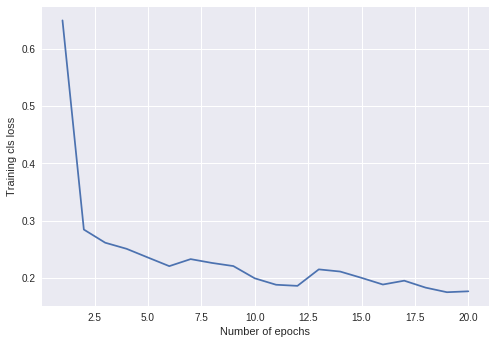

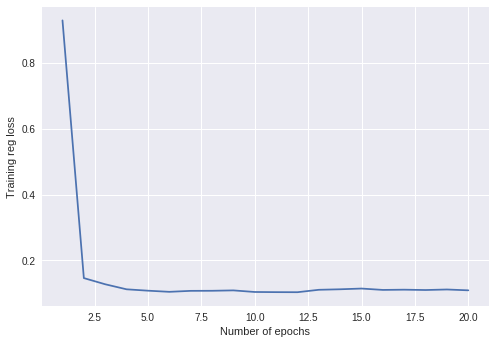

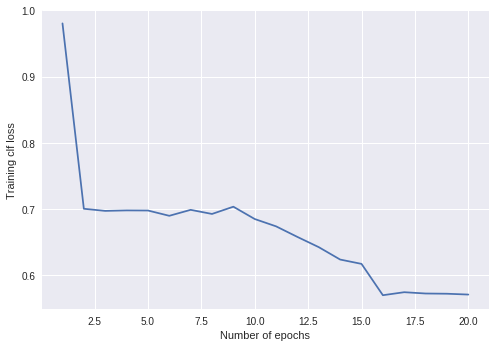

In [21]:
roi_id, roi_features, roi_labels = faster_rcnn(permutation, training_data, testing_data, training_labels, testing_labels, training_masks, testing_masks, training_stars, testing_stars, training_iou_ids, testing_iou_ids, w_a=3)

In [0]:
training_roi_features = roi_features[:1600]
testing_roi_features = roi_features[1600:]

training_roi_labels = roi_labels[:1600]
testing_roi_labels = roi_labels[1600:]

In [0]:
reset()

# Mask R-CNN
def mask_rcnn(roi_id, training_roi_features, testing_roi_features, training_roi_labels, testing_roi_labels, training_car_masks, testing_car_masks, training_ppl_masks, testing_ppl_masks):
  
  batch_size = 1
  
  # tf graph inputs
  x1 = tf.placeholder("float", [batch_size, 4, 4, 128])
  y1 = tf.placeholder("float", [batch_size, 22, 22, 1])
  y2 = tf.placeholder("float", [batch_size, 22, 22, 1])
  y3 = tf.placeholder("float", [batch_size, 1])
  
  # 4x4 mask predictions
  m1 = tf.nn.relu(tf.layers.batch_normalization(tf.layers.conv2d(x1, filters=128, kernel_size=[3,3], padding="SAME", kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1), name="conv11"), name="bn11"), name="relu11")
  m2 = tf.nn.relu(tf.layers.batch_normalization(tf.layers.conv2d(m1, filters=128, kernel_size=[3,3], padding="SAME", kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1), name="conv12"), name="bn12"), name="relu12")
  m3 = tf.nn.relu(tf.layers.batch_normalization(tf.layers.conv2d(m2, filters=1, kernel_size=[1,1], padding="SAME", kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1), name="conv13"), name="bn13"), name="relu13")
  
  # upsample to 22x22 masks
  up1 = tf.nn.relu(tf.layers.batch_normalization(tf.layers.conv2d_transpose(m3, filters=1, kernel_size=[3,3], strides=2, padding="valid", kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1), name="up14"), name="bn14"), name="relu14")
  up2 = tf.nn.relu(tf.layers.batch_normalization(tf.layers.conv2d_transpose(up1, filters=1, kernel_size=[3,3], strides=2, padding="valid", kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1), name="up15"), name="bn15"), name="relu15")
  up3 = tf.layers.conv2d_transpose(up2, filters=1, kernel_size=[4,4], strides=1, padding="valid", kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1), name="up16")
  
  # loss 
  loss_op = tf.where(y3 == 1., tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y1, logits=up3)), tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y2, logits=up3)))
  
  # binary mask prediction
  y_hat = tf.cast(tf.round(tf.nn.sigmoid(up3)), tf.float32)
  
  # accuracy of mask prediction
  correct_prediction = tf.where(y3 == 1., tf.cast(tf.equal(y_hat, y1), tf.float32), tf.cast(tf.equal(y_hat, y2), tf.float32))
  
  accuracy_operation = tf.reduce_mean(correct_prediction)
  
  # optimizer
  optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
  train_op = optimizer.minimize(loss_op)
  
  # initializing the variables
  init = tf.global_variables_initializer()
  
  with tf.Session() as sess:

      sess.run(init)

      training_loss_list = []
      
      testing_acc_list = []
      
      # training cycle
      for epoch in range(training_epochs):

          loss_tr = 0.
          
          acc_ts = 0.
          
          # loop over all batches
          for i in range(0, num_training_examples, batch_size):

              train_roi, train_roi_label, train_car_mask, train_ppl_mask = training_roi_features[i:i+batch_size], training_roi_labels[i:i+batch_size], training_car_masks[i:i+batch_size], training_ppl_masks[i:i+batch_size]
              
              train_car_mask = train_car_mask[:, :, :, np.newaxis]
              train_ppl_mask = train_ppl_mask[:, :, :, np.newaxis]
              
              _, loss = sess.run([train_op, loss_op], feed_dict={x1: train_roi, y1: train_car_mask, y2: train_ppl_mask, y3: train_roi_label})
              
              loss_tr += loss
              
          loss_tr = loss_tr/num_training_examples
          
          training_loss_list.append(loss_tr)
          
          if(epoch%4 == 0):
            print("\nEpoch: ", epoch+1, ", Training Loss: ", loss_tr, "\n")
          
          for j in range(0, num_testing_examples, batch_size):
            
              test_roi, test_roi_label, test_car_mask, test_ppl_mask = testing_roi_features[j:j+batch_size], testing_roi_labels[j:j+batch_size], testing_car_masks[j:j+batch_size], testing_ppl_masks[j:j+batch_size]
              
              test_car_mask = test_car_mask[:, :, :, np.newaxis]
              test_ppl_mask = test_ppl_mask[:, :, :, np.newaxis]
              
              acc = sess.run([accuracy_operation], feed_dict={x1: test_roi, y1: test_car_mask, y2: test_ppl_mask, y3: test_roi_label})

              acc_ts += acc[0]
          
          acc_ts = acc_ts/num_testing_examples
          
          testing_acc_list.append(acc_ts)
          
          if(epoch == 19):
            print("\nFinal Testing Accuracy: ", acc_ts, "\n")
      
      plt.plot(np.arange(len(training_loss_list))+1, training_loss_list)
      plt.xlabel("Number of epochs")
      plt.ylabel("Training loss")
      plt.show()


Epoch:  1 , Training Loss:  0.43527614370919765 


Epoch:  5 , Training Loss:  0.38281633018516004 


Epoch:  9 , Training Loss:  0.38080801754258575 


Epoch:  13 , Training Loss:  0.38066493315622213 


Epoch:  17 , Training Loss:  0.38063540294766424 


Final Testing Accuracy:  0.8304287168383598 



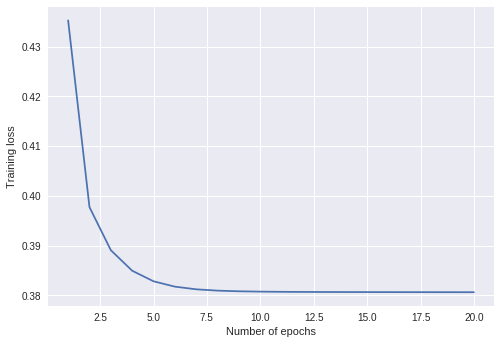

In [43]:
mask_rcnn(roi_id, training_roi_features, testing_roi_features, training_roi_labels, testing_roi_labels, training_car_masks, testing_car_masks, training_ppl_masks, testing_ppl_masks)